In [1]:
import pennylane as qml
from matplotlib import pyplot as plt
import numpy as np
from numpy import array
import pandas as pd
import scipy
from scipy.linalg import logm
from scipy.optimize import minimize
import networkx as nx
import seaborn
import itertools
%matplotlib inline

np.random.seed(42)

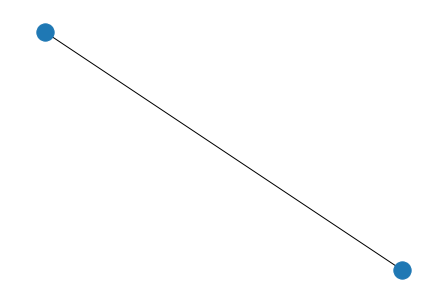

In [2]:
interaction_graph = nx.cycle_graph(2)
nx.draw(interaction_graph)

# VQT
* Definindo o hamiltonaino

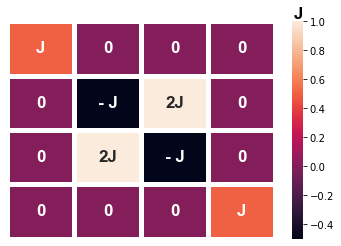

In [3]:
def create_hamiltonian_matrix(n, graph):

    matrix = np.zeros((2 ** n, 2 ** n))

    for i in graph.edges:
        x = y = z = 1
        for j in range(0, n):
            if j == i[0] or j == i[1]:
                x = np.kron(x, qml.matrix(qml.PauliX)(0))
                y = np.kron(y, qml.matrix(qml.PauliY)(0))
                z = np.kron(z, qml.matrix(qml.PauliZ)(0))
            else:
                x = np.kron(x, np.identity(2))
                y = np.kron(y, np.identity(2))
                z = np.kron(z, np.identity(2))

        matrix = 1/2*np.add(matrix, np.add(x, np.add(y, z)))

    return matrix


ham_matrix = create_hamiltonian_matrix(2, interaction_graph)

# Prints a visual representation of the Hamiltonian matrix
label1 = np.array([['J','0','0','0'],['0','- J','2J','0'],['0','2J','- J','0'],['0','0','0','J']])
seaborn.heatmap(ham_matrix.real, annot=label1,  linewidths=5, fmt = '', annot_kws = {'size':17,'fontweight': 'bold', 'fontname' :'arial'} )
plt.text(0.8, 0.93, 'J', transform=plt.gcf().transFigure, rotation=0, va='top', ha='center', fontsize=17, fontweight= 'bold', fontname='arial')
plt.xticks([])  # Remova rótulos do eixo x
plt.yticks([])
plt.show()

In [57]:
ham_matrix

array([[ 0.5+0.j,  0. +0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j, -0.5+0.j,  1. +0.j,  0. +0.j],
       [ 0. +0.j,  1. +0.j, -0.5+0.j,  0. +0.j],
       [ 0. +0.j,  0. +0.j,  0. +0.j,  0.5+0.j]])

* Criando o  ansatz

In [4]:
def sigmoid(x):
    return np.exp(x) / (np.exp(x) + 1)

def prob_dist(params):
    return np.vstack([sigmoid(params), 1 - sigmoid(params)]).T

def single_rotation(phi_params, qubits):

    rotations = ["Z", "Y", "X"]
    for i in range(0, len(rotations)):
        qml.AngleEmbedding(phi_params[i], wires=qubits, rotation=rotations[i])

nr_qubits = 2  
depth = 2

# A função single_rotation inclui as rotações X, Y e Z para 2 qubits
def single_rotation(phi_params, qubits):
    rotations = ["Z", "Y", "X"]  
    for i in range(0, len(rotations)):
        qml.AngleEmbedding(phi_params[i], wires=qubits, rotation=rotations[i])
dev = qml.device("lightning.qubit", wires=nr_qubits)

#dev = qml.device("lightning.qubit", wires=nr_qubits)

def quantum_circuit(rotation_params, coupling_params, sample=None):
    qml.BasisStatePreparation(sample, wires=range(nr_qubits))
    for i in range(0, depth):
        single_rotation(rotation_params[i], range(nr_qubits))
        qml.CRX(coupling_params[i], wires=range(nr_qubits))

    return qml.expval(qml.Hermitian(ham_matrix, wires=range(nr_qubits)))

qnode = qml.QNode(quantum_circuit, dev, interface="autograd")

* Calculando a entropia e defindo função auxíliar para lidar com formato da lista que é passada para o ansatz

In [5]:
def calculate_entropy(distribution):

    total_entropy = 0
    for d in distribution:
        total_entropy += -1 * d[0] * np.log(d[0]) + -1 * d[1] * np.log(d[1])

    # Returns an array of the entropy values of the different initial density matrices

    return total_entropy

def convert_list(params):

    # Separates the list of parameters
    dist_params = params[0:nr_qubits]
    ansatz_params_1 = params[nr_qubits : ((depth + 1) * nr_qubits)]
    ansatz_params_2 = params[((depth + 1) * nr_qubits) :]

    coupling = np.split(ansatz_params_1, depth)

    # Partitions the parameters into multiple lists
    split = np.split(ansatz_params_2, depth)
    rotation = []
    for s in split:
        rotation.append(np.split(s, 3))

    ansatz_params = [rotation, coupling]

    return [dist_params, ansatz_params]

* Cálculo do custo

In [6]:
def exact_cost(params):

    global iterations, beta
    # Transforms the parameter list
    parameters = convert_list(params)
    dist_params = parameters[0]
    ansatz_params = parameters[1]

    # Creates the probability distribution
    distribution = prob_dist(dist_params)

    # Generates a list of all computational basis states of our qubit system
    combos = itertools.product([0, 1], repeat=nr_qubits)
    s = [list(c) for c in combos]

    # Passes each basis state through the variational circuit and multiplies
    # the calculated energy EV with the associated probability from the distribution
    cost = 0
    for i in s:
        result = qnode(ansatz_params[0], ansatz_params[1], sample=i)
        for j in range(0, len(i)):
            result = result * distribution[j][i[j]]
        cost += result

    # Calculates the entropy and the final cost function
    entropy = calculate_entropy(distribution)
    final_cost = beta* cost - entropy

    final_cost_scalar = final_cost[1]  

    return final_cost_scalar

def cost_execution(params):

    global iterations

    cost = exact_cost(params)

    if iterations % 50 == 0:
        print("Cost at Step {}: {}".format(iterations, cost))

    iterations += 1
    return cost

In [7]:
#Teste
nr_qubits = 2
depth = 2
number = nr_qubits * (1 + depth * 4)
params = [np.random.randint(-300, 300) / 100 for i in range(0, int(number))]
params = np.array(params)
res = convert_list(params)


* Otimização

In [9]:
#Temp = np.linspace(1,50,50)
Temp = np.logspace(np.log10(0.5),np.log10(100),100)
beta_values = 4.2/Temp
iterations = 0
out_params_dict = {}
for beta in beta_values:
    out = minimize(cost_execution, x0=params, method="COBYLA", options={"maxiter": 1600})
    out_params = out["x"]
    out_params_dict[beta] = out_params

Cost at Step 0: -3.3599323478442944
Cost at Step 50: -11.641263357662512
Cost at Step 100: -13.100432527411929
Cost at Step 150: -13.553205990951426
Cost at Step 200: -13.830179860102076
Cost at Step 250: -14.064901078315806
Cost at Step 300: -14.129500837503347
Cost at Step 350: -14.209152206830598
Cost at Step 400: -14.277595328525777
Cost at Step 450: -14.332992177132038
Cost at Step 500: -14.356046245997671
Cost at Step 550: -14.394542045553251
Cost at Step 600: -14.424658602253567
Cost at Step 650: -14.443132750107164
Cost at Step 700: -14.458269715936225
Cost at Step 750: -14.47639119768838
Cost at Step 800: -14.493465910842692
Cost at Step 850: -14.506950654789295
Cost at Step 900: -14.51493032235048
Cost at Step 950: -14.523686171059532
Cost at Step 1000: -14.53210921292617
Cost at Step 1050: -14.539367043781743
Cost at Step 1100: -14.548450231184264
Cost at Step 1150: -14.555652784743469
Cost at Step 1200: -14.56260964721627
Cost at Step 1250: -14.566964041752925
Cost at Step 

In [37]:
#Preparando estado
def prepare_state(params, device):

    # Initialies the density matrix

    final_density_matrix = np.zeros((2 ** nr_qubits, 2 ** nr_qubits))

    # Prepares the optimal parameters, creates the distribution and the bitstrings
    parameters = convert_list(params)
    dist_params = parameters[0]
    unitary_params = parameters[1]

    distribution = prob_dist(dist_params)

    combos = itertools.product([0, 1], repeat=nr_qubits)
    s = [list(c) for c in combos]

    # Runs the circuit in the case of the optimal parameters, for each bitstring,
    # and adds the result to the final density matrix

    for i in s:
        qnode(unitary_params[0], unitary_params[1], sample=i)
        state = device.state
        for j in range(0, len(i)):
            state = np.sqrt(distribution[j][i[j]]) * state
        final_density_matrix = np.add(final_density_matrix, np.outer(state, np.conj(state)))

    return final_density_matrix

# Prepares the density matri

density_matrix_dict = {}

for beta, out_params in out_params_dict.items():
    # Calcula a matriz densidade para cada valor de beta usando os out_params correspondentes
    prep_density_matrix = prepare_state(out_params, dev)
    prep_density_matrix  = np.real(prep_density_matrix )

    # Armazena a matriz densidade no dicionário usando o valor de beta como chave

    density_matrix_dict[beta] = prep_density_matrix

In [38]:
#Entropia e susceptibilidade 
S = []
Chi = []
A   = [] 
for beta, density_matrix in density_matrix_dict.items():
    #Entropia
    rho = np.real(density_matrix_dict[beta])
    s = -np.trace(rho@logm(rho))
    S.append(s)
    #Susceptibilidade 
    a_11 = density_matrix[0, 0] 
    A.append(a_11)
    chi = 4*a_11
    Chi.append(chi)